In [116]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [142]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(False)

def trend(time, slope):
  return time * slope

def seasonal_pattern(season_time):
  return np.where(season_time < 0.1,
                  np.cos(season_time*6*np.pi),
                  2/np.exp(9*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [143]:
def generate_time_series():
  time = np.arange(4*365+1, dtype="float32")

  # initialize series
  y_intercept = 10
  slope = 0.005
  series = trend(time, slope) + y_intercept

  # add seasonality
  amplitude = 50
  series += seasonality(time, period=365, amplitude=amplitude)

  # add noise
  noise_level = 3
  series += noise(time, noise_level=noise_level, seed=42)

  return time, series

In [144]:
@dataclass
class G:
  TIME, SERIES = generate_time_series()
  SPLIT_TIME = 1100
  WINDOW_SIZE = 20
  BATCH_SIZE = 32
  SHUFFLE_BUFFER_SIZE = 1000

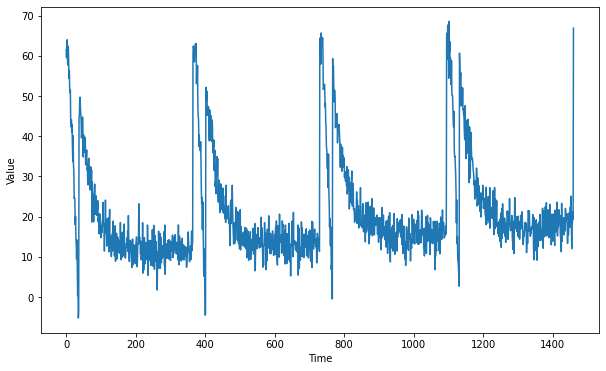

In [145]:
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [146]:
def train_val_split(time, series, timestep=G.SPLIT_TIME):
  train_time = time[:timestep]
  test_time = time[timestep:]

  x_train = series[:timestep]
  x_test = series[timestep:]

  return train_time, test_time, x_train, x_test

In [147]:
train_time, test_time, x_train, x_test =  train_val_split(G.TIME, G.SERIES)

In [148]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda w: (w[:-1], w[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [149]:
test_dataset = windowed_dataset(x_train, window_size=1, batch_size=5, shuffle_buffer=1)
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [150]:
f, l = next((iter(test_dataset)))

In [151]:
f

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[61.490143],
       [59.523552],
       [61.686604],
       [63.98522 ],
       [58.254543]], dtype=float32)>

In [152]:
l

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([59.523552, 61.686604, 63.98522 , 58.254543, 57.66498 ],
      dtype=float32)>

In [153]:
f.shape, l.shape

(TensorShape([5, 1]), TensorShape([5]))

In [154]:
np.allclose(f.numpy().flatten(), x_train[:5])

True

In [155]:
np.allclose(l.numpy(), x_train[1:6])

True

In [156]:
type(f), type(l)

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [157]:
def create_model(window_size=G.WINDOW_SIZE):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation="relu", input_shape=[window_size]),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6), loss="mse")
  return model

In [158]:
model = create_model()
dataset = windowed_dataset(x_train)
model.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 3ms/step - loss: 567.6895
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 142.7009
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 111.5873
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 103.9497
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 98.0084
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 92.7045
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 87.9067
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 83.4323
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 79.4169
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 75.7583
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 72.5386
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 69.6008
Epoch 13/100
34/34 [=

In [159]:
def compute_metrics(true_series, forecast):
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast)
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast)
  return mse, mae

In [160]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time+window_size][np.newaxis]))
  forecast = forecast[split_time-window_size:]
  results = np.array(forecast)[:, 0, 0]
  return results

1/1 [==============================] - 0s 18ms/step


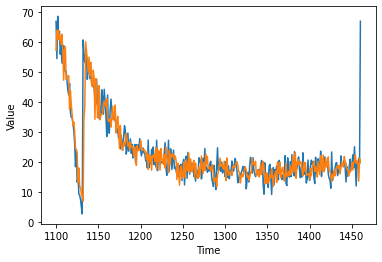

In [161]:
dnn_forecast = generate_forecast()

In [162]:
mse, mae = compute_metrics(test_time, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1591970.88, mae: 1256.76 for forecast


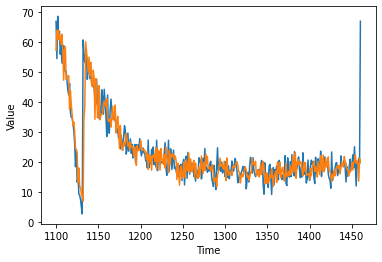

In [163]:
plot_series(test_time, x_test)
plot_series(test_time, dnn_forecast)